In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

import tensorflow as tf
#from tensorflow import set_random_seed
#tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from keras.models import Sequential
from keras import optimizers


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
!pip install keras.utils

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN,GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
from keras import optimizers
#from keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path ='/content/drive/MyDrive/ICAS/normal.csv'
train = pd.read_csv(path,usecols=[18,19,20,30,31,32])
last=(train.shape[0]//3)*3
train=train[0:last]
train

,angular_velocity.x,angular_velocity.y,angular_velocity.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z
0,0.001359,0.002366,0.000258,0.961052,-0.245166,9.796843
1,-0.002334,0.003354,0.001427,0.490333,-0.245166,9.894910
2,-0.003173,0.002272,0.002434,0.284393,-0.156906,9.855683
3,-0.002579,0.002873,0.002923,0.696272,-0.313813,9.904716
4,-0.000993,0.003704,0.002703,0.872792,-0.284393,9.708584
...,...,...,...,...,...,...
856,0.000282,0.000079,0.000286,0.284393,-0.225553,9.845877
857,0.000133,0.000561,0.000801,0.245166,-0.205940,9.845877
858,-0.001297,0.001588,0.001245,0.254973,-0.147100,9.855683
859,-0.001468,0.001852,0.000171,0.304006,-0.166713,9.885103


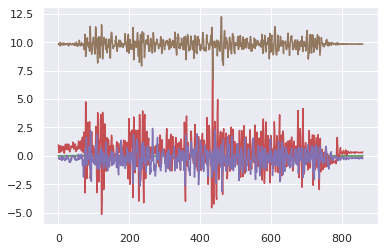

In [ ]:
# plot the variation vs time i
plt.plot(train)

In [ ]:
path2 ='/content/drive/MyDrive/ICAS/icab2_abnormal1.csv'
path1 ='/content/drive/MyDrive/ICAS/abnormal2.csv'
path ='/content/drive/MyDrive/ICAS/abnormal1.csv'
test = pd.read_csv(path,usecols=[18,19,20,30,31,32])
test=test[0:(test.shape[0]//3)*3]
test.index=test.index+last
test

,angular_velocity.x,angular_velocity.y,angular_velocity.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z
861,0.001369,0.003281,-0.003239,0.421686,-0.215746,9.885103
862,-0.000466,0.002388,-0.003293,0.411879,-0.294199,9.875297
863,-0.001836,0.002453,-0.002719,0.411879,-0.304006,9.894910
864,-0.001633,0.004359,-0.001778,0.411879,-0.294199,9.875297
865,0.000206,0.005041,-0.002078,0.402073,-0.264780,9.885103
...,...,...,...,...,...,...
2302,-0.001603,0.001664,-0.001208,0.451106,-0.392266,9.875297
2303,-0.001596,0.002113,-0.002849,0.362846,-0.392266,9.826263
2304,-0.001849,0.004086,-0.001547,0.284393,-0.451106,9.855683
2305,-0.001895,0.003308,-0.000129,0.284393,-0.382459,9.865490


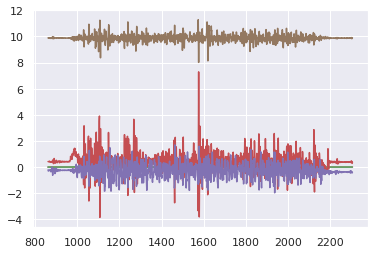

In [ ]:
# plot the variation vs time i
plt.plot(test)

In [ ]:
#train = train[1: 700]
#test = data[701:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (861, 6)
Test dataset shape: (1446, 6)


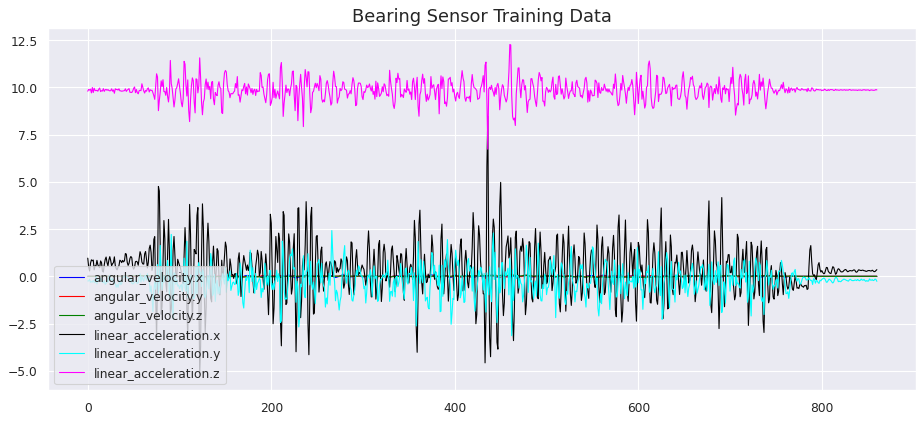

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['angular_velocity.x'], label='angular_velocity.x', color='blue', animated = True, linewidth=1)
ax.plot(train['angular_velocity.y'], label='angular_velocity.y', color='red', animated = True, linewidth=1)
ax.plot(train['angular_velocity.z'], label='angular_velocity.z', color='green', animated = True, linewidth=1)
ax.plot(train['linear_acceleration.x'], label='linear_acceleration.x', color='black', animated = True, linewidth=1)
ax.plot(train['linear_acceleration.y'], label='linear_acceleration.y', color='cyan', animated = True, linewidth=1)
ax.plot(train['linear_acceleration.z'], label='linear_acceleration.z', color='magenta', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
X_train = X_train.reshape(X_train.shape[0]//3,3, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0]//3,3, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (287, 3, 6)
Test data shape: (482, 3, 6)


In [ ]:
def autoencoder_model(X):
  time_step = 3
  n_features = 6
  model=Sequential()
  model.add(LSTM(128,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
  model.add(LSTM(64,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=False))
  model.add(RepeatVector(time_step))
  model.add(LSTM(64,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
  model.add(LSTM(128,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
  model.add(TimeDistributed(Dense(n_features,activation="sigmoid")))
  # plot_model(model, to_file='Submission_LSTM_autoencoder.png', show_shapes=True,show_layer_names=False)
  model.compile(optimizer=optimizers.Adam(lr=0.01),loss="mse", metrics=["accuracy"])
  return model

In [ ]:
model = autoencoder_model(X_train)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 3, 128)            69120     
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_31 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 3, 6)              774       
Total params: 251,142
Trainable params: 251,142
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
28/28 [==============================] - 8s 62ms/step - loss: 0.0169 - accuracy: 0.2716 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0142 - accuracy: 0.4039 - val_loss: 0.0018 - val_accuracy: 0.3333
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0114 - accuracy: 0.4518 - val_loss: 3.0903e-04 - val_accuracy: 0.5111
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0091 - accuracy: 0.5337 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 5/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0098 - accuracy: 0.5372 - val_loss: 4.5532e-04 - val_accuracy: 1.0000
Epoch 6/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0081 - accuracy: 0.5539 - val_loss: 3.6895e-04 - val_accuracy: 1.0000
Epoch 7/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0084 - accuracy: 0.5318 - val_loss: 4.5628e-04 - val_acc

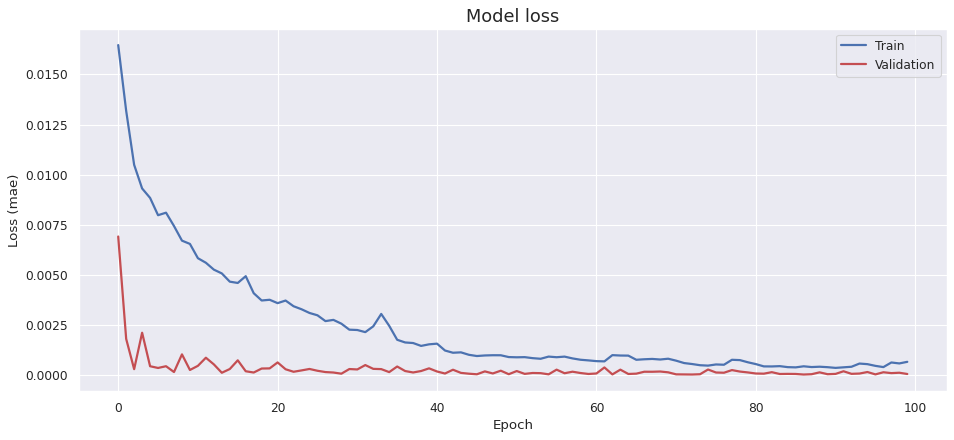

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16.0, 14.0)
matplotlib.style.use('ggplot')
import scipy.stats as st

def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme",
                  "beta","betaprime","bradford","burr","burr12","cauchy","chi","chi2","cosine","dgamma","alpha",
                  "dweibull","erlang","expon","exponweib","exponpow","fatiguelife","fisk",
                  "cauchy","foldnorm","f","genlogistic","gamma","genpareto","genexpon","genextreme",
                  "gengamma","genhalflogistic","gennorm","gilbrat","gompertz","gumbel_r",
                  "gumbel_l","halfcauchy","halfnorm","halflogistic","hypsecant","gausshyper","invgamma","invgauss",
                  "invweibull","johnsonsb","ksone","johnsonsu","kstwobign","laplace","levy_l",
                  "levy","loglaplace","loggamma","lognorm","maxwell","mielke",
                  "nakagami","ncx2","pareto","lomax","powernorm",
                  "powerlaw","rdist","rayleigh","rice","recipinvgauss","semicircular",
                  "t","trapz","triang","truncexpon","truncnorm",
                  "tukeylambda","vonmises","uniform","wald","weibull_max","weibull_min","logistic"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

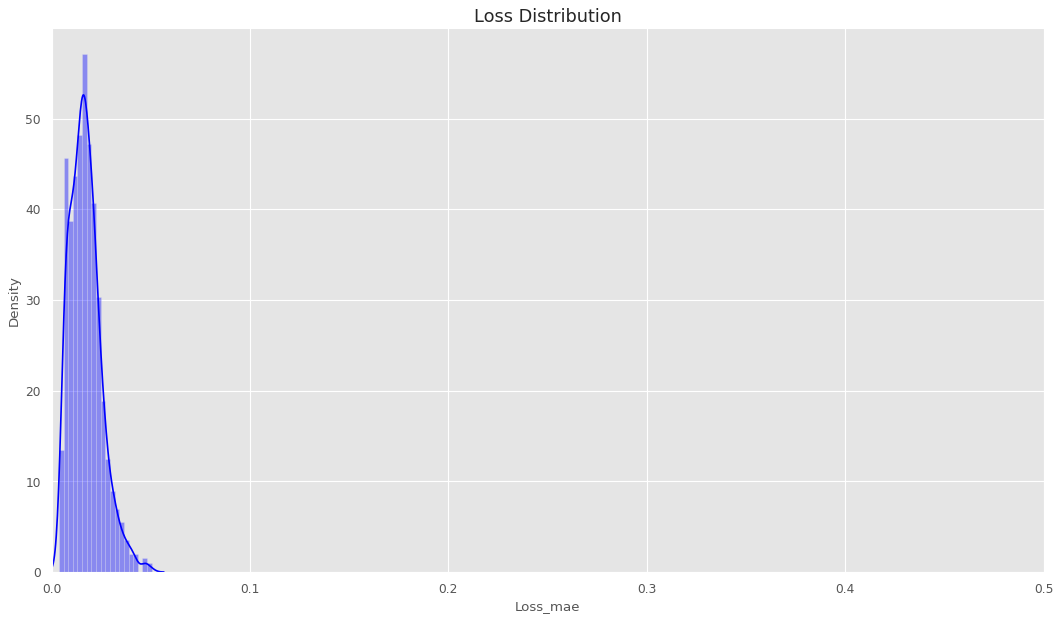

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
error = np.array(scored['Loss_mae'])
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
get_best_distribution(error)

p value for norm = 0.014128299646319125
p value for exponweib = 0.2653445367799856
p value for weibull_max = 1.5336816547675433e-166
p value for weibull_min = 0.3079054212047906
p value for pareto = 5.912615834997121e-27


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:708: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:712: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


p value for genextreme = 2.0331733459348445e-23
p value for beta = 0.13029711105693695
p value for betaprime = 7.250298332378886e-10
p value for bradford = 1.4647159229837472e-23
p value for burr = 0.00017706711678539493
p value for burr12 = 0.23417055805939463
p value for cauchy = 1.6191062098288812e-10
p value for chi = 0.4815546043219681
p value for chi2 = 0.09317587105716378
p value for cosine = 0.0
p value for dgamma = 0.00629364566595544
p value for alpha = 0.18517523539772426
p value for dweibull = 0.007682058338915236
p value for erlang = 0.09320561315499466
p value for expon = 2.1432462929268066e-27


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2847: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 5.25.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2847: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.75.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2847: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.833333333333334.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2847: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 4.958333333333334.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2847: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer

p value for exponweib = 0.2653445367799856
p value for exponpow = 0.002149947203137323
p value for fatiguelife = 0.017684932436001655
p value for fisk = 0.0
p value for cauchy = 1.6191062098288812e-10
p value for foldnorm = 1.9810675157951038e-59
p value for f = 2.0848053592491247e-294
p value for genlogistic = 0.18210294556684958
p value for gamma = 0.09315599156508468
p value for genpareto = 3.304017427151917e-41


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


p value for genexpon = 1.6392549014115257e-07
p value for genextreme = 2.0331733459348445e-23
p value for gengamma = 0.19731719142740278
p value for genhalflogistic = 1.1336217254020272e-06
p value for gennorm = 0.009356924101565965
p value for gilbrat = 3.978568581404474e-13
p value for gompertz = 1.7206431123108148e-13
p value for gumbel_r = 0.17300769293276436
p value for gumbel_l = 1.3646753128044953e-18
p value for halfcauchy = 4.053127752637044e-31
p value for halfnorm = 7.587008266975388e-14
p value for halflogistic = 9.804501665613082e-17
p value for hypsecant = 0.0032925487604244952


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


p value for gausshyper = 0.2755733179733576
p value for invgamma = 0.1754248779050138
p value for invgauss = 0.025413849804485075
p value for invweibull = 0.1707133223029036
p value for johnsonsb = 0.10806302128455661
p value for ksone = 1.1341022695108301e-100


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:97: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:100: RuntimeWarning: floating point number truncated to an integer
  return scu._smirnovc(n, x)


p value for johnsonsu = 0.1692279221246332
p value for kstwobign = 0.23184935724624867
p value for laplace = 0.0005167711973975425
p value for levy_l = 5.79062838863667e-266
p value for levy = 5.697421645191479e-103
p value for loglaplace = 0.0
p value for loggamma = 0.007607061959260793


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:4789: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


p value for lognorm = 0.02772633573062244
p value for maxwell = 0.21737536150366968
p value for mielke = 0.08361038120946983
p value for nakagami = 0.4819846920587583
p value for ncx2 = 0.08515535940974986
p value for pareto = 5.912615834997121e-27
p value for lomax = 9.183779240311738e-16
p value for powernorm = 0.0
p value for powerlaw = 1.1635454109913763e-78
p value for rdist = 0.0
p value for rayleigh = 0.2250250983300469
p value for rice = 0.22463984413345583
p value for recipinvgauss = 0.0331223181836895
p value for semicircular = 0.0
p value for t = 0.014490856966538398
p value for trapz = 0.0
p value for triang = 3.32329997932343e-26
p value for truncexpon = 1.515088045422697e-37
p value for truncnorm = 1.4943556959448918e-106


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:7248: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


p value for tukeylambda = 0.010749272324590518
p value for vonmises = 0.0
p value for uniform = 1.0707773807315129e-130
p value for wald = 1.5584450273606663e-11
p value for weibull_max = 1.5336816547675433e-166
p value for weibull_min = 0.3079054212047906
p value for logistic = 0.009581571961355685
Best fitting distribution: nakagami
Best p value: 0.4819846920587583
Parameters for the best fit: (0.8383054011536952, 0.003592251547454335, 0.015631788634089025)


('nakagami',
 0.4819846920587583,
 (0.8383054011536952, 0.003592251547454335, 0.015631788634089025))

0.03151124966256439


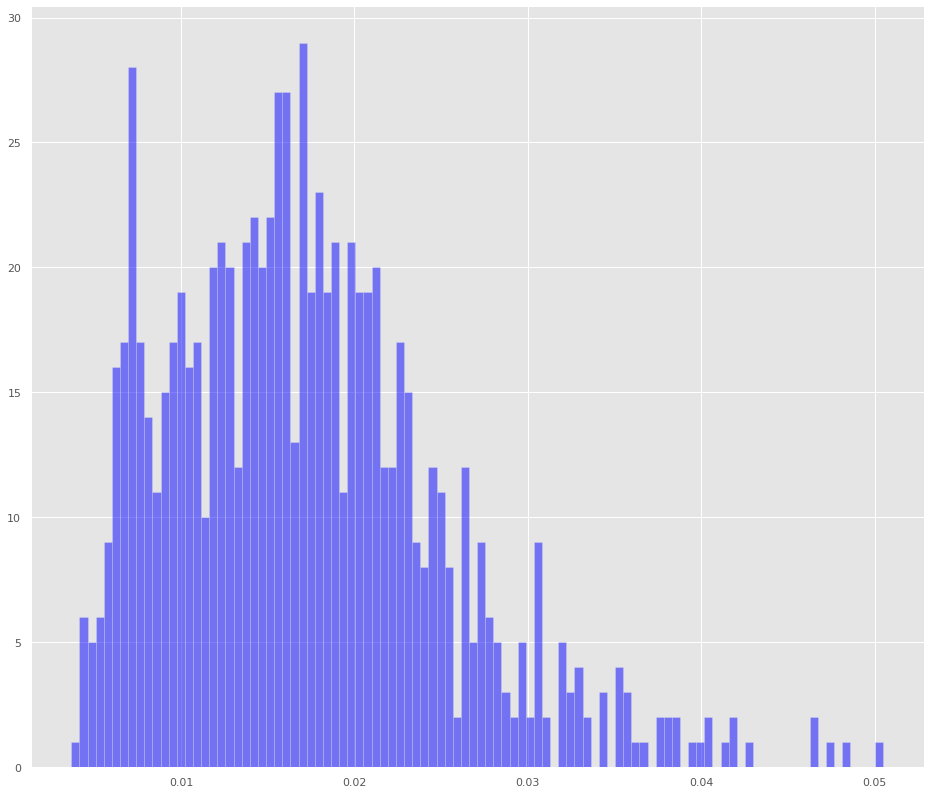

In [ ]:
dist = stats.nakagami(0.8383054011536952, 0.003592251547454335, 0.015631788634089025)
#Finding the threshold 
print (dist.ppf(0.95))
x = error
num_bins = 100
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)

print(scored['Loss_mae'].shape)
scored['Threshold'] = 0.03151124966256439
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

(1446,)


,Loss_mae,Threshold,Anomaly
861,0.005310,0.031511,False
862,0.007596,0.031511,False
863,0.007640,0.031511,False
864,0.006658,0.031511,False
865,0.006065,0.031511,False


In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0]* X_pred_train.shape[1],X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
print(scored_train['Loss_mae'].shape)
scored_train['Threshold'] = 0.03151124966256439
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored_fin = pd.concat([scored_train, scored],axis=0)
print(scored_fin['Loss_mae'].shape)
scored_train.head()

(861,)
(2307,)


,Loss_mae,Threshold,Anomaly
0,0.007739,0.031511,False
1,0.007069,0.031511,False
2,0.007968,0.031511,False
3,0.007644,0.031511,False
4,0.009673,0.031511,False


plt.plot(scored_fin['Loss_mae'])

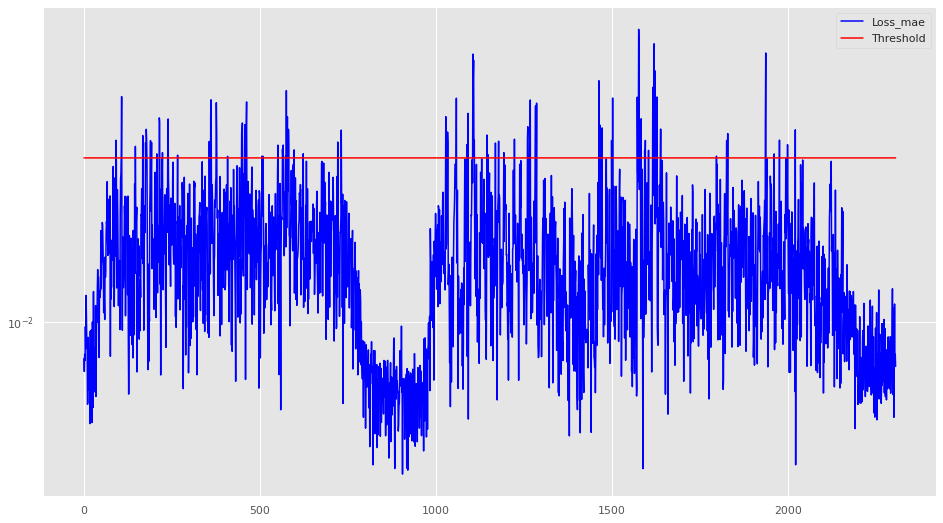

In [ ]:
# plot bearing failure time plot
scored_fin.plot(logy=True,  figsize=(16,9), color=['blue','red'])

In [ ]:

# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved


In [ ]:
y_test_predic = model.predict(X_test)

In [ ]:
dif = X_test - y_test_predic
SSD = np.sum((X_test[:,:,:]-y_test_predic[:,:,:])**2)
print('SSD value:',SSD/(X_test.size))
print('Accuracy:',1- SSD/(X_test.size))

SSD value: 0.0004186955237701459
Accuracy: 0.9995813044762298
